<a href="https://colab.research.google.com/github/xtliao/PyTorchProjects/blob/main/nn_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A ConvNet practice on MNIST dataset


# 1.&nbsp;Prep MNIST dataset and dataloader.




In [36]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1.1. Get the train and test dataset from MNIST dataset

In [37]:
train_dataset = MNIST(root="data",
                      train=True,
                      transform=transforms.ToTensor(),
                      target_transform=None,
                      download=True
                      )
test_dataset = MNIST(root="data",
                      train=False,
                      transform=transforms.ToTensor(),
                      target_transform=None,
                      download=True
                      )

print(f"Length of train dataset: {len(train_dataset):,}\n")
print(f"Length of test dataset: {len(test_dataset):,}\n")

input, label = train_dataset[0]
print(f"Shape of input: {input.shape} \n")
print(f"Lable: {label} \n")

class_names = train_dataset.classes
print(f"There are {len(class_names)} classes in the dataset: \n")
print(f"{class_names}")

Length of train dataset: 60,000

Length of test dataset: 10,000

Shape of input: torch.Size([1, 28, 28]) 

Lable: 5 

There are 10 classes in the dataset: 

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 1.2. Plot some random data from the train dataset

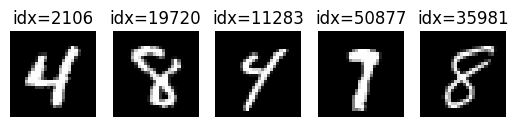

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random

NUM_SAMPLES = 5
random_sample_ids = random.sample(range(0, len(train_dataset)), k=NUM_SAMPLES)
random_sample_ids

fig, axs = plt.subplots(1, NUM_SAMPLES)
for i, idx in enumerate(random_sample_ids):
  axs[i].imshow(train_dataset[idx][0].squeeze(), cmap="gray")
  axs[i].axis(False)
  axs[i].set_title(f"idx={idx}")


## 1.3 Convert into dataloader

In [39]:
BATCH_SIZE = 32

train_dataloder = DataLoader(dataset=train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloder = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

print(f"Length of train dataloder: {len(train_dataloder):,}\n")
print(f"Length of test dataloder: {len(test_dataloder):,}\n")


Length of train dataloder: 1,875

Length of test dataloder: 313



# 2.&nbsp;Define training and testing loop functions.

## 2.1 Define train_loop()

In [40]:
def train_loop(model: torch.nn.Module,
               train_dataloder: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               metric_fn,
               device: torch.device = device):
  model.train()
  model.to(device)

  train_loss, train_metric = 0, 0
  for batch, (X, y) in enumerate(train_dataloder):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    loss = loss_fn(y_logits, y)

    y_pred = y_logits.softmax(dim=1).argmax(dim=1)
    metric = metric_fn(y_pred, y)

    train_loss += loss.detach()
    train_metric += metric.detach()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_loss/len(train_dataloder), train_metric/len(train_dataloder)


## 2.2 Define test_loop()

In [41]:
def test_loop(model: torch.nn.Module,
              test_dataloder: torch.utils.data.DataLoader,
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              metric_fn,
              device: torch.device = device):
  model.eval()
  model.to(device)

  with torch.inference_mode():
    test_loss, test_metric = 0 ,0
    for batch, (X_test, y_test) in enumerate(test_dataloder):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_logits = model(X_test)
      loss = loss_fn(test_logits, y_test)

      test_pred = test_logits.softmax(dim=1).argmax(dim=1)
      metric = metric_fn(test_pred, y_test)

      test_loss += loss.detach()
      test_metric += metric.detach()

  return test_loss/len(test_dataloder), test_metric/len(test_dataloder)

# 3.&nbsp;Define training model function to use training and test loop functions.

In [48]:
from tqdm.auto import tqdm

def train_model(model: torch.nn.Module,
                train_dataloder: torch.utils.data.DataLoader,
                test_dataloder: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                metric_fn,
                device: torch.device = device,
                epochs: int = 5):

  results = {"train_loss": [],
            "train_metric": [],
            "test_loss":[],
            "test_metric": []}

  for epoch in tqdm(range(epochs), desc="Training model..."):
    train_loss, train_metric = train_loop(model=model,
                                          train_dataloder=train_dataloder,
                                          optimizer=optimizer,
                                          loss_fn = loss_fn,
                                          metric_fn=metric_fn,
                                          device=device)

    test_loss, test_metric = test_loop(model=model,
                                       test_dataloder=test_dataloder,
                                       optimizer=optimizer,
                                       loss_fn= loss_fn,
                                       metric_fn = metric_fn,
                                       device=device)

    print(f"Epoch:{epoch:3n} | Train loss:{train_loss:.5f}, train metric:{train_metric:.2%} | Test loss:{test_loss:.5f}, test metric:{test_metric:.2%}")

    results["train_loss"].append(train_loss.item())
    results["train_metric"].append(train_metric.item())
    results["test_loss"].append(test_loss.item())
    results["test_metric"].append(test_metric.item())

  return results

# 4.&nbsp;Define model by replicating CNN Explainer: https://poloclub.github.io/cnn-explainer/

## 4.1 Define the model class

In [43]:
import torch.nn as nn

class MyMNISTModel(nn.Module):
  def __init__(self, input_shapes: int, hidden_units: int, output_shapes: int):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shapes,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units,3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
    nn.Conv2d(hidden_units, hidden_units,3, 1, 1),
    nn.ReLU(),
    nn.Conv2d(hidden_units, hidden_units,3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7,
                  out_features=output_shapes)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    # print(f"Shape after conv1:{x.shape}")
    x = self.conv2(x)
    # print(f"Shape after conv2:{x.shape}")
    x = self.classifier(x)
    # print(f"Shape after classifier:{x.shape}")
    return x

model_0 = MyMNISTModel(input_shapes=1,
                       hidden_units=10,
                       output_shapes=len(class_names))
model_0


MyMNISTModel(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 4.2 Test the new model

In [44]:
X, y = train_dataset[0]
y_pred = model_0(X.unsqueeze(0)).softmax(dim=1).argmax(dim=1)
print(f"X.shape:{X.shape}, y:{y}, prediction:{y_pred.item()}")

X.shape:torch.Size([1, 28, 28]), y:5, prediction:0


# 5.&nbsp;Define loss function, accuracy function and optimizer.

## 5.1. Use metric functions in trochmetrics package

In [45]:
try:
  import torchmetrics
except:
  !pip install torchmetrics --quiet
  import torchmetrics

## 5.2. Define the functions

In [46]:
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

from torchmetrics.classification import MulticlassAccuracy
acc_fn = MulticlassAccuracy(num_classes=len(class_names))

# 6.&nbsp;Train the model.

In [49]:
import timeit


start = timeit.default_timer()

NUM_EPOCHS = 3

model_0_results = train_model(model=model_0,
                              train_dataloder=train_dataloder,
                              test_dataloder=test_dataloder,
                              optimizer=optimizer,
                              loss_fn = loss_fn,
                              metric_fn=acc_fn,
                              device = device,
                              epochs=NUM_EPOCHS)

end = timeit.default_timer()
model_0_train_time = end-start

print()
print(f"Train time is:{model_0_train_time:.2f} seconds")
print(f"Train results are:")
print(f"Train loss:{model_0_results['train_loss']}")
print(f"Train acc:{model_0_results['train_metric']}")
print(f"Test loss:{model_0_results['test_loss']}")
print(f"Test acc:{model_0_results['test_metric']}")


Training model...:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:  0 | Train loss:0.10575, train metric:96.53% | Test loss:0.08141, test metric:97.28%
Epoch:  1 | Train loss:0.09959, train metric:96.60% | Test loss:0.08850, test metric:97.08%
Epoch:  2 | Train loss:0.09538, train metric:96.80% | Test loss:0.08868, test metric:96.70%

Train time is:179.57 seconds
Train results are:

Train loss:[0.1057533398270607, 0.09958872944116592, 0.09538130462169647]
Train acc:[0.9653108716011047, 0.9659709930419922, 0.9679707288742065]
Test loss:[0.08140838146209717, 0.08849883824586868, 0.0886768326163292]
test acc:[0.9728295207023621, 0.9707678556442261, 0.9670481085777283]


# 7.&nbsp;Make predictions and eval the model.

# 8.&nbsp;Plot the loss and accuracy curves.

# 9.&nbsp;Plot the confusion matrix.

# 10.&nbsp;Plot some of the wrong predictions.

# 11.&nbsp;Save the model.